In [138]:
import kagglehub
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD
from scipy.stats import loguniform, randint


In [139]:
# Download latest version
path = kagglehub.dataset_download("arshkon/linkedin-job-postings")
print(path)


C:\Users\mason\.cache\kagglehub\datasets\arshkon\linkedin-job-postings\versions\13


In [140]:
os.listdir(path)

['companies', 'jobs', 'mappings', 'postings.csv']

In [141]:
postings_path = os.path.join(path, "postings.csv")
postings = pd.read_csv(postings_path)

postings.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [142]:
# basic exploration
postings.info()
postings.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                     23320 non-null   float64
 13  original_liste

job_id                             0
company_name                    1719
title                              0
description                        7
max_salary                     94056
pay_period                     87776
location                           0
company_id                      1717
views                           1689
med_salary                    117569
min_salary                     94056
formatted_work_type                0
applies                       100529
original_listed_time               0
remote_allowed                108603
job_posting_url                    0
application_url                36665
application_type                   0
expiry                             0
closed_time                   122776
formatted_experience_level     29409
skills_desc                   121410
listed_time                        0
posting_domain                 39968
sponsored                          0
work_type                          0
currency                       87776
c

**Create a usable salary target**

In [143]:
postings['pay_period'].value_counts()

pay_period
YEARLY      20628
HOURLY      14741
MONTHLY       518
WEEKLY        177
BIWEEKLY        9
Name: count, dtype: int64

In [144]:
# Normalize salaries to yearly amounts

def normalize_salary(row):
    if pd.isna(row['min_salary']) and pd.isna(row['max_salary']) and pd.isna(row['med_salary']):
        return row['min_salary'], row['max_salary'], row['med_salary']  # nothing to convert
    
    period = row['pay_period']
    
    factor = {
        'YEARLY': 1,
        'HOURLY': 2080,
        'WEEKLY': 52,
        'BIWEEKLY': 26,
        'MONTHLY': 12
    }.get(period, 1)
    
    return (
        row['min_salary'] * factor if not pd.isna(row['min_salary']) else None,
        row['max_salary'] * factor if not pd.isna(row['max_salary']) else None,
        row['med_salary'] * factor if not pd.isna(row['med_salary']) else None
    )

postings[['min_salary', 'max_salary', 'med_salary']] = postings.apply(
    lambda row: pd.Series(normalize_salary(row)),
    axis=1
)


In [145]:
postings['salary_target'] = postings['med_salary']

missing_med = postings['salary_target'].isna()
postings.loc[missing_med, 'salary_target'] = (
    (postings.loc[missing_med, 'min_salary'] + 
     postings.loc[missing_med, 'max_salary']) / 2
)

In [146]:
postings['salary_target'].count()

np.int64(36073)

In [147]:
# drop rows with missing salary_target
postings = postings.dropna(subset=['salary_target'])

In [148]:
# remove rows with salary over $400,000 to avoid model distortion
postings = postings[postings['salary_target'] <= 400000]


In [149]:
# Check pay_period is all normalized as expected
print(postings['pay_period'].value_counts())

# Quick look at the new salary scales
postings['salary_target'].describe()


pay_period
YEARLY      20511
HOURLY      14696
MONTHLY       516
WEEKLY        177
BIWEEKLY        3
Name: count, dtype: int64


count     35903.000000
mean      93857.595587
std       54863.484936
min           0.000000
25%       51693.200000
50%       81000.000000
75%      124800.000000
max      400000.000000
Name: salary_target, dtype: float64

**Handle missing values without leaking data**

In [150]:
postings['description'] = postings['description'].fillna('')
postings['remote_allowed'] = postings['remote_allowed'].fillna(0)

**Feature Engineering**

In [151]:
def add_engineered_features(postings: pd.DataFrame) -> pd.DataFrame:
    df = postings.copy()

    # --- Seniority from title + description ---
    def get_seniority(text: str) -> str:
        t = text.lower()
        if 'intern' in t or 'internship' in t:
            return 'intern'
        if 'junior' in t or ' jr ' in t or ' jr.' in t:
            return 'junior'
        if any(w in t for w in ['senior', ' sr ', ' sr.', 'sr ']):
            return 'senior'
        if any(w in t for w in ['lead', 'principal', 'staff', 'director', 'vp', 'vice president', 'head of']):
            return 'lead_plus'
        return 'mid'

    combined_text = (df['title'].fillna('') + ' ' + df['description'].fillna(''))
    df['seniority'] = combined_text.apply(get_seniority)

    # --- Description length (word count) ---
    df['desc_len'] = df['description'].fillna('').str.split().str.len()

    # --- Skill keyword counts ---
    skill_patterns = {
        'python':   r'\bpython\b',
        'sql':      r'\bsql\b',
        'aws':      r'\baws\b|\bamazon web services\b',
        'excel':    r'\bexcel\b',
        'tableau':  r'\btableau\b',
        'powerbi':  r'\bpower ?bi\b',
        'ml':       r'\bmachine learning\b',
        'dl':       r'\bdeep learning\b',
    }

    text_all_lower = combined_text.str.lower()

    for name, pattern in skill_patterns.items():
        df[f'skill_{name}'] = text_all_lower.str.count(pattern)

    return df

# Apply feature engineering
postings_fe = add_engineered_features(postings)

**Feature set**

In [152]:
# Feature columns (we still keep raw text for TF-IDF)
skill_cols = [c for c in postings_fe.columns if c.startswith('skill_')]

feature_cols = [
    'title',
    'description',
    'location',
    'formatted_work_type',
    'remote_allowed',
    'seniority',
    'desc_len',
] + skill_cols

X = postings_fe[feature_cols]
y = postings_fe['salary_target']


**Train test split**

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Preprocessing**

In [ ]:
# Categorical + numeric groups
skill_cols = [c for c in X.columns if c.startswith('skill_')]

cat_features = ['location', 'formatted_work_type', 'seniority']
num_features = ['remote_allowed', 'desc_len'] + skill_cols

# Transformers
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('title_tfidf',
         TfidfVectorizer(max_features=3000, min_df=3),
         'title'),
        ('desc_tfidf',
         TfidfVectorizer(max_features=5000, min_df=5),
         'description'),
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features),
    ]
)

**Pipeline**

In [155]:
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('reduce_dim', TruncatedSVD(n_components=100, random_state=42)),
    ('model', ElasticNet(max_iter=5000))  # overwritten by RandomizedSearchCV
])

pipeline

,steps,"[('preprocess', ...), ('reduce_dim', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('title_tfidf', ...), ('desc_tfidf', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [156]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:.3f}")

MAE:  40,656.37
RMSE: 52,840.95
R²:   0.085


**Parameter Grid**

In [157]:
fast_param_search = [

    # --- Ridge ---
    {
        'model': [Ridge()],
        'model__alpha': loguniform(1e-2, 1e2),
        'reduce_dim__n_components': randint(50, 150),
    },

    # --- ElasticNet ---
    {
        'model': [ElasticNet(max_iter=5000)],
        'model__alpha': loguniform(1e-3, 1e1),
        'model__l1_ratio': [0.2, 0.5, 0.8],
        'reduce_dim__n_components': randint(50, 150),
    },

]


**Randomized Search**

In [158]:
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=fast_param_search,
    n_iter=10,                        # reduced for speed
    scoring='neg_mean_absolute_error',
    cv=2,                            # reduced CV folds
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


,estimator,Pipeline(step..._iter=5000))])
,param_distributions,"[{'model': [Ridge()], 'model__alpha': <scipy.stats....0024FC1675C90>, 'reduce_dim__n_components': <scipy.stats....0024E4F847610>}, {'model': [ElasticNet(max_iter=5000)], 'model__alpha': <scipy.stats....0024F7471C850>, 'model__l1_ratio': [0.2, 0.5, ...], 'reduce_dim__n_components': <scipy.stats....0024F747CFC50>}]"
,n_iter,10
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,2
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


**Best Model**

In [159]:
print("Best model:", search.best_estimator_)
print("Best params:", search.best_params_)
print("Best CV MAE:", search.best_score_)

best_model = search.best_estimator_

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test MAE:  {mae:,.2f}")
print(f"Test RMSE: {rmse:,.2f}")
print(f"Test R²:   {r2:.3f}")

Best model: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('title_tfidf',
                                                  TfidfVectorizer(max_features=3000,
                                                                  min_df=3),
                                                  'title'),
                                                 ('desc_tfidf',
                                                  TfidfVectorizer(max_features=5000,
                                                                  min_df=5),
                                                  'description'),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                         

**Feature Importance**

In [160]:
# Get the most important SVD components
coefs = best_model.named_steps['model'].coef_
importance = np.abs(coefs)
sorted_idx = np.argsort(importance)[::-1]

top_10_components = sorted_idx[:10]
print(top_10_components)

[ 24 112  49  29 109  31 144  35  23  25]


In [ ]:
# Interpret SVD components
feature_names = best_model.named_steps['preprocess'].get_feature_names_out()
svd = best_model.named_steps['reduce_dim']

idx = 44  # choose from above
loading = svd.components_[idx]

top_words = np.argsort(np.abs(loading))[-20:]
print([feature_names[i] for i in top_words])


['num__skill_ml', 'title_tfidf__coordinator', 'cat__formatted_work_type_Temporary', 'title_tfidf__of', 'desc_tfidf__and', 'cat__location_Dallas, TX', 'title_tfidf__associate', 'title_tfidf__analyst', 'title_tfidf__sales', 'title_tfidf__representative', 'title_tfidf__specialist', 'cat__location_Washington, DC', 'title_tfidf__director', 'cat__location_Phoenix, AZ', 'title_tfidf__customer', 'title_tfidf__service', 'cat__formatted_work_type_Internship', 'title_tfidf__senior', 'cat__location_Austin, TX', 'num__skill_dl']


**Seniority matters most**

Director and senior-level language produces large positive salary shifts.

**Technical AI/ML skills boost salary**

Machine learning & deep learning keywords are highly predictive of higher compensation.

**Location influences salary**

High-cost metros (DC) lean high-salary; mid-tier cities (Dallas, Phoenix) lean lower.

**Role type is a huge divider**

Customer service, coordinator, representative, specialist → low salaries.
Leadership, technical skills, ML roles → high salaries.

**Work type is a strong negative signal**

Temporary and internship roles on average pay far less.

In [166]:
# Updated list of interpreted top features:
top_features = [
    'num__skill_ml',
    'title_tfidf__coordinator',
    'cat__formatted_work_type_Temporary',
    'title_tfidf__of',
    'desc_tfidf__and',
    'cat__location_Dallas, TX',
    'title_tfidf__associate',
    'title_tfidf__analyst',
    'title_tfidf__sales',
    'title_tfidf__representative',
    'title_tfidf__specialist',
    'cat__location_Washington, DC',
    'title_tfidf__director',
    'cat__location_Phoenix, AZ',
    'title_tfidf__customer',
    'title_tfidf__service',
    'cat__formatted_work_type_Internship',
    'title_tfidf__senior',
    'cat__location_Austin, TX',
    'num__skill_dl'
]

# Get SVD + preprocess mapping
pre = best_model.named_steps["preprocess"]
svd = best_model.named_steps["reduce_dim"]
coefs = best_model.named_steps["model"].coef_

# Build DataFrame with feature contributions
feature_importances = []

for feat in top_features:
    # Get original feature index in the preprocessor
    feature_names = pre.get_feature_names_out()
    idx = np.where(feature_names == feat)[0]
    if len(idx) == 0:
        continue  # skip if not found
    idx = idx[0]

    # Contribution = sum over SVD components:
    # coef_k * loading_k(feature)
    contribution = np.dot(coefs, svd.components_[:, idx])

    feature_importances.append((feat, contribution))

df_imp = pd.DataFrame(feature_importances, columns=["Feature", "Contribution"])

# Sort by absolute effect (largest impact at the top)
df_imp["Abs"] = df_imp["Contribution"].abs()
df_imp = df_imp.sort_values("Abs", ascending=True).reset_index(drop=True)

df_imp.head(20)


,Feature,Contribution,Abs
0,title_tfidf__sales,1276.583694,1276.583694
1,"cat__location_Austin, TX",1482.794661,1482.794661
2,"cat__location_Phoenix, AZ",-2514.508037,2514.508037
3,title_tfidf__service,-4730.123598,4730.123598
4,"cat__location_Dallas, TX",4809.827748,4809.827748
5,num__skill_dl,7064.229044,7064.229044
6,num__skill_ml,7245.393292,7245.393292
7,"cat__location_Washington, DC",13529.286629,13529.286629
8,title_tfidf__customer,-16762.893933,16762.893933
9,title_tfidf__representative,-19736.932536,19736.932536


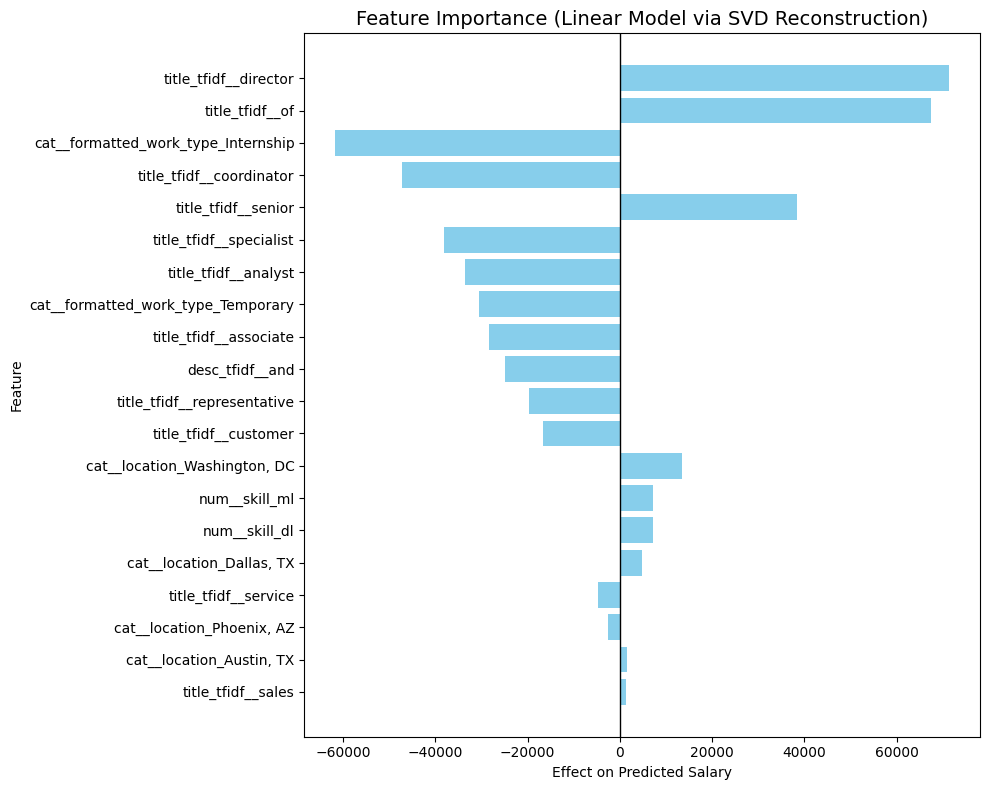

In [167]:
plt.figure(figsize=(10, 8))
plt.barh(df_imp["Feature"], df_imp["Contribution"], color="skyblue")
plt.axvline(0, color='black', linewidth=1)
plt.title("Feature Importance (Linear Model via SVD Reconstruction)", fontsize=14)
plt.xlabel("Effect on Predicted Salary")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()